In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
#from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy
import netCDF4 as nc 
#from sklearn.metrics import r2_score
#from sklearn.preprocessing import StandardScaler
import pickle
from scipy.odr import ODR, Model, Data, RealData
from matplotlib import gridspec
import os


In [2]:
save_fig = 0

## Fonctions for the analysis

In [27]:
def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    # m.shadedrelief(scale=scale)
    m.drawlsmask(land_color='gray',ocean_color='white',lakes=True)
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion


def mask_high_error(stddev, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(stddev)):
        for j in range(len(stddev[0])):
            if stddev[i][j] >= inversion[i][j]*(20/100):
                new_inversion[i][j] = np.nan
    return new_inversion


def mask_sie(sie_map, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(sie_map)):
        for j in range(len(sie_map[0])):
            if not np.isnan(sie_map[i][j]) and sie_map[i][j] < 0.7:
                new_inversion[i][j] = np.nan
    return new_inversion


def pearson(inverse, OIB):
    # pearson coefficient
    ydata = np.array(inverse)
    yfit = np.array(OIB)

    ydata_mean = np.mean(ydata)
    yfit_mean = np.mean(yfit)

    data_diff = ydata - ydata_mean
    fit_diff = yfit - yfit_mean

    top = np.sum( (data_diff) * (fit_diff) )

    bottom = np.sqrt( np.sum(data_diff**2) * np.sum(fit_diff**2) )

    r = top/bottom

    return r

def analyse (calculated_data, validation_data):
    error = np.array(calculated_data) - np.array(validation_data)
    md = np.mean(error)
    rmse = np.sqrt( np.mean( (error)**2 ))
    residuals = error**2
    denom = (calculated_data - np.mean(calculated_data)) ** 2
    r2 = 1 - (np.sum(residuals) / np.sum(denom))

    # Calculate slope and y-intercept
    #slope, intercept = np.polyfit(validation_data, calculated_data, 1)
    data = RealData(validation_data, calculated_data)
    model = Model(model_func)
    beta0 = [1.0, 0.0]
    odr = ODR(data, model, beta0=beta0)
    output = odr.run()

    slope = output.beta[0]
    intercept = output.beta[1]


    return md, rmse, r2, slope, intercept


## Validation for snow

In [4]:
## Validation against OIB

OIB_files = ["/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190408.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190412.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190419.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190420.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190422.nc"]

inverse_ice = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_snow.npy']

awismos_file = ['/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201904-fv2p4.nc']

awismos = nc.Dataset(awismos_file[0])
awismos.variables.keys()
SD_awismos = awismos.variables['snow_depth'][0][36:396,36:396][::-1, :]

lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

sie_path = '/home/erb/masterproject/MSCI_project/snow_ice/carmen/SIE/SIE_masking_25km_2018-2019_season.pkl'
f = open(sie_path,'rb')
sie_file = pickle.load(f)
sie_map  = sie_file['20190415']


SD_uit = np.load('/home/erb/masterproject/MSCI_project/validation_data/UIT_data/snow_201904_EASE2_laku_UIT.npy')


/tmp/ipykernel_226291/623803841.py:15: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  SD_awismos = awismos.variables['snow_depth'][0][36:396,36:396][::-1, :]
/tmp/ipykernel_226291/623803841.py:15: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  SD_awismos = awismos.variables['snow_depth'][0][36:396,36:396][::-1, :]


In [5]:
def snow_OIB(OIB_files):

    SD_OIB = nc.Dataset(OIB_files).variables['Snow Depth'][:,:]
    return SD_OIB

In [6]:
SD_OIB, SD_OIB_awi = [], []
SD_OIB_uit = []
snow_inverse = []
snow_awismos = []
snow_uit = []


for i in range(len(OIB_files)):
    
    file_OIB = snow_OIB(OIB_files[i])
    inverse_snow_data = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1500_iteration1500000_date_window7j_errorinput_alphacs20.75_hierarchicalno_snow.npy')
    inverse_snow_stddev = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1500_iteration1500000_date_window7j_errorinput_alphacs20.75_hierarchicalno_snow_stddev.npy')

    inverse_snow_data = mask_high_error(inverse_snow_stddev, inverse_snow_data)
    #inverse_snow_data = mask_sie(sie_map, inverse_snow_data)

    for k in range(360):
        for j in range(360):
            if not (file_OIB.mask[k][j]) and not np.isnan(inverse_snow_data[k][j]):
                snow_inverse.append(inverse_snow_data[k][j])
                SD_OIB.append(file_OIB[k][j])


for i in range(len(OIB_files)):
    
    file_OIB = snow_OIB(OIB_files[i])

    for k in range(360):
        for j in range(360):
            if not (file_OIB.mask[k][j]) and not np.isnan(SD_awismos[k][j]):
                snow_awismos.append(SD_awismos[k][j])
                SD_OIB_awi.append(file_OIB[k][j])


for i in range(len(OIB_files)):
    
    file_OIB = snow_OIB(OIB_files[i])

    for k in range(360):
        for j in range(360):
            if not (file_OIB.mask[k][j]) and not np.isnan(SD_uit[k][j]):
                snow_uit.append(SD_uit[k][j])
                SD_OIB_uit.append(file_OIB[k][j])

FileNotFoundError: [Errno 2] No such file or directory: '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1500_iteration1500000_date_window7j_errorinput_alphacs20.75_hierarchicalno_snow.npy'

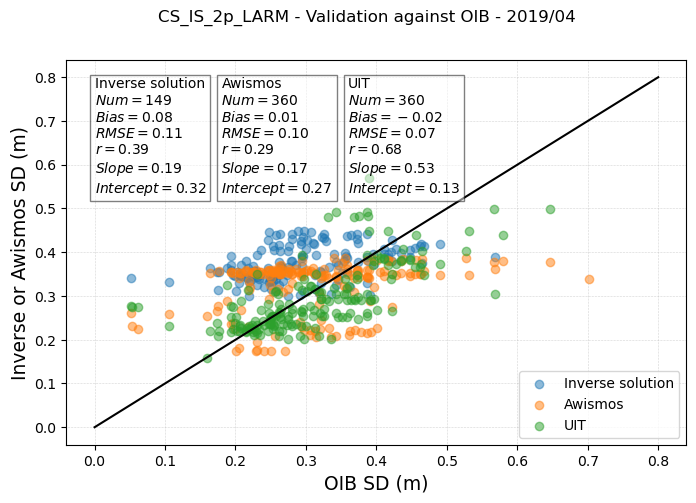

In [ ]:
fig = plt.figure(figsize = (8, 5))
plt.suptitle('CS_IS_2p_LARM - Validation against OIB - 2019/04')

plt.scatter(SD_OIB, snow_inverse, alpha = 0.5, label = 'Inverse solution')
plt.scatter(SD_OIB_awi, snow_awismos, alpha = 0.5, label = 'Awismos')
plt.scatter(SD_OIB_uit, snow_uit, alpha = 0.5, label = 'UIT')
plt.plot([0,0.8] , [0,0.8], 'k-')
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('OIB SD (m)', fontsize = 13.5)
plt.ylabel('Inverse or Awismos SD (m)', fontsize = 13.5)
plt.legend(loc = 'lower right')

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_inverse, SD_OIB)
r_snow = pearson(SD_OIB, snow_inverse)

textstr = '\n'.join((
    rf'Inverse solution',
    rf'$Num = {len(snow_inverse)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0, 0.8, textstr, bbox=box_props, verticalalignment='top')

x_values = np.array([0,0.8])
y_values = slope * x_values + intercept
#plt.plot(x_values, y_values, 'k--', label = 'Inverse solution')


md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_awismos, SD_OIB_awi)
r_snow = pearson(SD_OIB_awi, snow_awismos)

textstr = '\n'.join((
    rf'Awismos',
    rf'$Num = {len(SD_awismos)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.18, 0.8, textstr, bbox=box_props, verticalalignment='top')

# Regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept
#plt.plot(x_values, y_values, 'k', label = "Awismos solution")

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_uit, SD_OIB_uit)
r_snow = pearson(SD_OIB_uit, snow_uit)

textstr = '\n'.join((
    rf'UIT',
    rf'$Num = {len(SD_uit)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.36, 0.8, textstr, bbox=box_props, verticalalignment='top')

# Regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept
#plt.plot(x_values, y_values, 'k', label = "UIT solution")




In [4]:
## Validation against MOSAiC

date = ['20191115', '20191215', '20200115', '20200215', '20200315', '20200415']

mosaic_files = ['/home/erb/masterproject/MSCI_project/validation_data/various_data/UIT_MOSAIC/20191115.nc',
                '/home/erb/masterproject/MSCI_project/validation_data/various_data/UIT_MOSAIC/20191215.nc',
                '/home/erb/masterproject/MSCI_project/validation_data/various_data/UIT_MOSAIC/20200115.nc',
                '/home/erb/masterproject/MSCI_project/validation_data/various_data/UIT_MOSAIC/20200215.nc',
                '/home/erb/masterproject/MSCI_project/validation_data/various_data/UIT_MOSAIC/20200315.nc',
                '/home/erb/masterproject/MSCI_project/validation_data/various_data/UIT_MOSAIC/20200415.nc']



is_files = ["/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2019_25km_20191115.npy",
            "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2019_25km_20191215.npy",
            "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2020_25km_20200115.npy",
            "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2020_25km_20200215.npy",
            "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2020_25km_20200315.npy",
            "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2020_25km_20200415.npy"]
cs_files = ["/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20191115.npy",
            "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20191215.npy",
            "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20200115.npy",
            "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20200215.npy",
            "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20200315.npy",
            "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20200415.npy"]


inverse_snow_files = ["/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201911/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy",
                      "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201912/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy", 
                      "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202001/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy", 
                      "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202002/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy",
                      "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202003/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy",
                      "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202004/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy"]

awismos_snow_files = ['/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201911-fv2p4.nc',
                      '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201912-fv2p4.nc',
                      '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202001-fv2p4.nc',
                      '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202002-fv2p4.nc',
                      '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202003-fv2p4.nc',
                      '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202004-fv2p4.nc']

snow_awi, snow_mosaic = [], []

for i in range(len(date)):
    snow_awi.append(nc.Dataset(awismos_snow_files[i]).variables['snow_depth'][0][36:396,36:396][::-1, :])
    snow_mosaic.append(nc.Dataset(mosaic_files[i]).variables['Snow Depth'][:,:])

snow_inverse =[]
snow_compare_inverse = []
snow_awismos = []
snow_compare_awismos = []

DENSITY_WATER = 997.0
DENSITY_ICE = 917.0      
DENSITY_SNOW = 300.0
SPEED_OF_LIGHT_VACUUM_OVER_SPEED_OF_LIGHT_SNOW = 1.28

for i in range(5):
    
    A = (DENSITY_WATER - DENSITY_ICE) / DENSITY_WATER
    B = 1 - SPEED_OF_LIGHT_VACUUM_OVER_SPEED_OF_LIGHT_SNOW -DENSITY_SNOW/DENSITY_WATER
    D = 1 - DENSITY_SNOW/DENSITY_WATER

    Hi = (A*np.load(cs_files[i]) - B*np.load(is_files[i]))/ A*(D-B)
    Hs = (np.load(cs_files[i]) - np.load(is_files[i])) / (B -D)

    snow_inverse_data = np.load(inverse_snow_files[i])
    snow_inverse_data = mask_observations(Hi,snow_inverse_data)

    for k in range(360):
        for j in range(360):
            if not (snow_mosaic[i].mask[k][j]) and not np.isnan(snow_inverse_data[k][j]):
                snow_inverse.append(snow_inverse_data[k][j])
                snow_compare_inverse.append(snow_mosaic[i].data[k][j])
                
    for k in range(360):
        for j in range(360):
            if not (snow_mosaic[i].mask[k][j]) and not np.isnan(snow_awi[i][k][j]):
                snow_awismos.append(snow_awi[i][k][j])
                snow_compare_awismos.append(snow_mosaic[i].data[k][j])




/tmp/ipykernel_194348/3722079799.py:45: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  snow_awi.append(nc.Dataset(awismos_snow_files[i]).variables['snow_depth'][0][36:396,36:396][::-1, :])
/tmp/ipykernel_194348/3722079799.py:45: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  snow_awi.append(nc.Dataset(awismos_snow_files[i]).variables['snow_depth'][0][36:396,36:396][::-1, :])


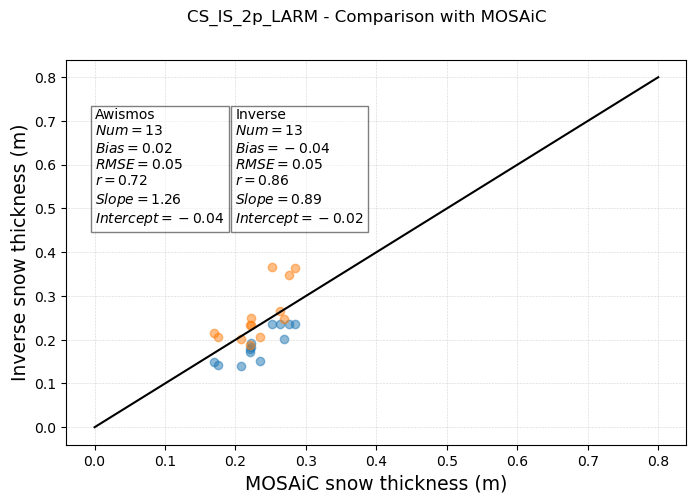

In [8]:
fig = plt.figure(figsize=(8, 5))


plt.suptitle('CS_IS_2p_LARM - Comparison with MOSAiC')

#ax = fig.add_subplot(121)
plt.scatter(snow_compare_inverse, snow_inverse, alpha = 0.5)
plt.scatter(snow_compare_awismos, snow_awismos, alpha = 0.5)
plt.plot([0,0.8] , [0,0.8], 'k-')
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('MOSAiC snow thickness (m)', fontsize = 13.5)
plt.ylabel('Inverse snow thickness (m)', fontsize = 13.5)
#ax.set_title("Agreement plot for inverse snow model")

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_inverse, snow_compare_inverse)
r_snow = pearson(snow_compare_inverse, snow_inverse)

textstr = '\n'.join((
    rf'Inverse',
    rf'$Num = {len(snow_inverse)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.2, 0.73, textstr, bbox=box_props, verticalalignment='top')

# Regression line
x_values = np.array([0,0.8])
y_values = slope * x_values + intercept
#plt.plot(x_values, y_values, 'k--')

md_ice_inverse, rmse_ice_inverse, r2_ice_inverse, slope, intercept = analyse(snow_awismos, snow_compare_awismos)
r_ice = pearson(snow_compare_awismos, snow_awismos)

textstr = '\n'.join((
    rf'Awismos',
    rf'$Num = {len(snow_awismos)}$',
    rf'$Bias={md_ice_inverse:.2f}$',
    rf'$RMSE={rmse_ice_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.001, 0.73, textstr, bbox=box_props, verticalalignment='top')

x_values = np.array([0,0.8])
y_values = slope * x_values + intercept
#plt.plot(x_values, y_values, '--k', label ="Awismos")


save_fig = 0

if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation/non_interpolated/validation_MOSAiC' + year + '.png')


In [18]:
# Comparison against SMLG

snow_file = nc.Dataset("/home/erb/masterproject/MSCI_project/validation_data/various_data/SMLG_snod_EASE.nc")
snow_11 = snow_file.variables['Snow Depth'][3607, :, :]
snow_12 = snow_file.variables['Snow Depth'][3636, :, :]
snow_01 = snow_file.variables['Snow Depth'][3667, :, :]
snow_02 = snow_file.variables['Snow Depth'][3697, :, :]
snow_03 = snow_file.variables['Snow Depth'][3727, :, :]
snow_04 = snow_file.variables['Snow Depth'][3758, :, :]
snow_file.close()
snow_lg = [snow_11,snow_12,snow_01,snow_02,snow_03,snow_04]

is_files = ["/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2019_25km_20191115.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2019_25km_20191215.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2020_25km_20200115.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2020_25km_20200215.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2020_25km_20200315.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2020_25km_20200415.npy"]

cs_files = ["/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20191115.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20191215.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20200115.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20200215.npy",
      "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20200315.npy",
       "/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/CS2_LARM/FB_interp_2019-2020_25km_20200415.npy"]

inverse_snow_files = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201911/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy',
                        '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201912/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy',
                        '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202001/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy',
                        '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202002/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy',
                        '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202003/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy',
                        '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202004/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy']

# grids
lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

In [19]:
snow_inverse =[]
snow_compare = []

DENSITY_WATER = 997.0
DENSITY_ICE = 917.0
DENSITY_SNOW = 300.0
SPEED_OF_LIGHT_VACUUM_OVER_SPEED_OF_LIGHT_SNOW = 1.28

for i in range(5):
    
    A = (DENSITY_WATER - DENSITY_ICE) / DENSITY_WATER
    B = 1 - SPEED_OF_LIGHT_VACUUM_OVER_SPEED_OF_LIGHT_SNOW -DENSITY_SNOW/DENSITY_WATER
    D = 1 - DENSITY_SNOW/DENSITY_WATER

    Hi = (A*np.load(cs_files[i]) - B*np.load(is_files[i]))/ A*(D-B)
    Hs = (np.load(cs_files[i]) - np.load(is_files[i])) / (B -D)

    snow_inverse_data = np.load(inverse_snow_files[i])
    snow_inverse_data = mask_observations(Hi,snow_inverse_data)

    for k in range(360):
        for j in range(360):
            if not (snow_lg[i].mask[k][j]) and not np.isnan(snow_inverse_data[k][j]):
                snow_inverse.append(snow_inverse_data[k][j])
                snow_compare.append(snow_lg[i].data[k][j])

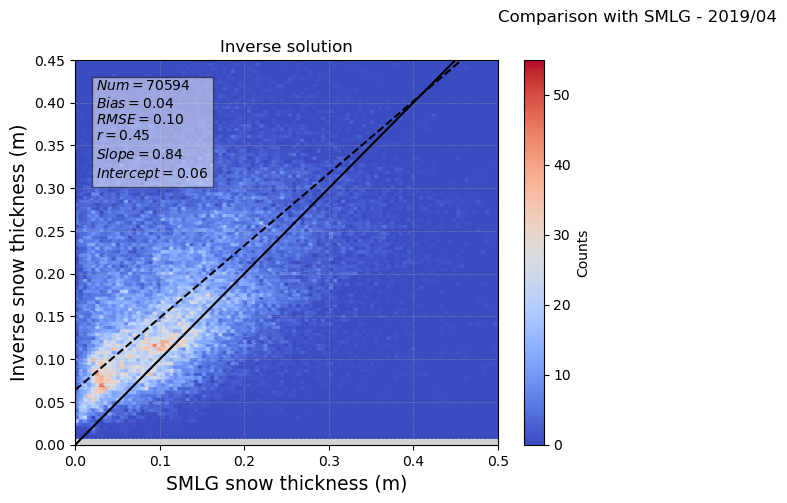

In [28]:
fig = plt.figure(figsize=(15, 5))
plt.suptitle('Comparison with SMLG - 2019/04')

plt.subplot(121)
plt.title('Inverse solution')
#plt.scatter(snow_compare, snow_inverse, alpha = 0.5)
plt.hexbin(snow_compare, snow_inverse, gridsize=200, cmap='coolwarm')
plt.plot([0,0.8] , [0,0.8], 'k-')
plt.ylim(0, 0.45)
plt.xlim(0, 0.5)
plt.colorbar(label='Counts')
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('SMLG snow thickness (m)', fontsize = 13.5)
plt.ylabel('Inverse snow thickness (m)', fontsize = 13.5)

ax = plt.gca()
ax.set_facecolor('lightgrey')

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(snow_inverse, snow_compare)
r_snow = pearson(snow_compare, snow_inverse)

textstr = '\n'.join((
    rf'$Num = {len(snow_inverse)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'
    ))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

# Regression line

x_values = np.array([0,0.8])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--', label='Linear Regression')

save_fig = 0

year = '2019/04'

if save_fig == 1 :
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation/non_interpolated/validation_SMLG' + year + '.png')



In [24]:
import numpy as np
from scipy.odr import ODR, Model, Data, RealData

# Définir la fonction du modèle (ex : une droite y = m*x + b)
def model_func(beta, x):
    m, b = beta  # beta contient les paramètres du modèle (pente, ordonnée à l'origine)
    return m * x + b


data = RealData(snow_compare, snow_inverse)
model = Model(model_func)
beta0 = [1.0, 0.0]
odr = ODR(data, model, beta0=beta0)
output = odr.run()

# Afficher les résultats
print("Paramètres estimés (m, b) : ", output.beta)
print("Erreurs associées aux paramètres : ", output.sd_beta)
print("Résidu réduit : ", output.res_var)



Paramètres estimés (m, b) :  0.8438717150437706
Erreurs associées aux paramètres :  [0.00395082 0.0005926 ]
Résidu réduit :  0.003857427809779615


## Validation for ice

In [4]:
def ice_icebird(icebird_file):

    SIT_icebird = nc.Dataset(icebird_file).variables['sea_ice_thickness'][:,:]
    return SIT_icebird

In [7]:
## Validation against IceBird

icebird_file = ['/home/erb/masterproject/MSCI_project/validation_data/IceBird_data/binned_data_Icebird/20190407.nc',
                '/home/erb/masterproject/MSCI_project/validation_data/IceBird_data/binned_data_Icebird/20190408.nc',
                '/home/erb/masterproject/MSCI_project/validation_data/IceBird_data/binned_data_Icebird/20190410.nc']

awismos_file = ['/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_week/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-20190401_20190407-fv2p4.nc']

awismos = nc.Dataset(awismos_file[0])
awismos.variables.keys()
SIT_awismos = awismos.variables['sea_ice_thickness'][0][36:396,36:396][::-1, :]

IB_array = []
for i in range(len(icebird_file)):
    IB_array.append(nc.Dataset(icebird_file[i]).variables['sea_ice_thickness'][:,:])

In [8]:
SIT_icebird = []
ice_inverse = []


for i in range(len(icebird_file)):
    
    file_icebird = ice_icebird(icebird_file[i])
    inverse_ice_data = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1000_iteration1000000_date_window3j_error0.05_alphacs20.75_hierarchicalno_ice.npy')
    inverse_ice_stddev = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1000_iteration1000000_date_window3j_error0.05_alphacs20.75_hierarchicalno_ice_stddev.npy')
    inverse_ice_data = mask_high_error(inverse_ice_stddev, inverse_ice_data)
    for k in range(360):
        for j in range(360):
            if not (file_icebird.mask[k][j]) and not np.isnan(inverse_ice_data[k][j]):
                ice_inverse.append(inverse_ice_data[k][j])
                SIT_icebird.append(file_icebird[k][j])


SIT_icebird_2 = []
ice_awismos = []


for i in range(len(icebird_file)):
    
    file_icebird = ice_icebird(icebird_file[i])

    for k in range(360):
        for j in range(360):
            if not (file_icebird.mask[k][j]) and not np.isnan(SIT_awismos[k][j]):
                ice_awismos.append(SIT_awismos[k][j])
                SIT_icebird_2.append(file_icebird[k][j])


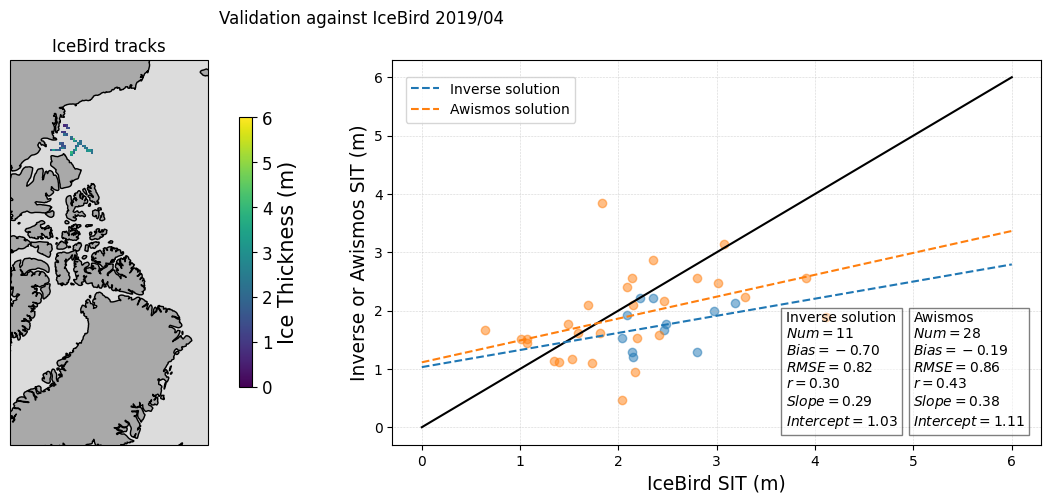

In [41]:
fig = plt.figure(figsize = (17,5))
spec = gridspec.GridSpec(ncols=2, nrows=1,wspace=0.1, height_ratios=[1], width_ratios=[1.4, 1.5])

plt.suptitle('Validation against IceBird 2019/04')

lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

ax1 = fig.add_subplot(spec[0], projection=ccrs.NorthPolarStereo())
ax1.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax1.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax1.coastlines()
ax1.set_extent([-180, -20, 85, 70], ccrs.PlateCarree())
p_map = ax1.pcolormesh(lon_g,lat_g, IB_array[0],cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 6)
p_map = ax1.pcolormesh(lon_g,lat_g, IB_array[1],cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 6)
p_map = ax1.pcolormesh(lon_g,lat_g, IB_array[2],cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 6)
plt.title('IceBird tracks')
a = fig.colorbar(p_map,shrink=0.7, pad=0.05, orientation = 'vertical')
a.ax.tick_params(labelsize=12)
a.set_label('Ice Thickness (m)',fontsize=15)


ax2 = fig.add_subplot(spec[1])
ax2.scatter(SIT_icebird, ice_inverse, alpha = 0.5)
ax2.scatter(SIT_icebird_2, ice_awismos, alpha = 0.5)
ax2.plot([0,6] , [0,6], 'k-')
ax2.grid(linestyle='dotted', linewidth ='0.4')
ax2.set_xlabel('IceBird SIT (m)', fontsize = 13.5)
ax2.set_ylabel('Inverse or Awismos SIT (m)', fontsize = 13.5)

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(ice_inverse, SIT_icebird)
r_snow = pearson(SIT_icebird, ice_inverse)

textstr = '\n'.join((
    rf'Inverse solution',
    rf'$Num = {len(ice_inverse)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
ax2.text(3.7, 2, textstr, bbox=box_props, verticalalignment='top')

x_values = np.array([0,6])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, '--', label = 'Inverse solution')


md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(ice_awismos, SIT_icebird_2)
r_snow = pearson(SIT_icebird_2, ice_awismos)

textstr = '\n'.join((
    rf'Awismos',
    rf'$Num = {len(ice_awismos)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
ax2.text(5, 2, textstr, bbox=box_props, verticalalignment='top')

# Regression line
x_values = np.array([0,6])
y_values = slope * x_values + intercept
ax2.plot(x_values, y_values, '--', label = "Awismos solution")

fig.legend(loc = "upper right",bbox_to_anchor=(0.63, 0.86))

save_fig = 1
if save_fig == 1: 
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation/validation_icebird_ice', dpi = 300)



In [ ]:
## Validation against BGEP
BGEP_file_ULSA = nc.Dataset('/home/erb/masterproject/MSCI_project/validation_data/BGEP_data/BGEP_data/ULS_A/SMLG_ERA5_SIT_EASE_01Jan2010-30Apr2021.nc')
BGEP_file_ULSB = nc.Dataset('/home/erb/masterproject/MSCI_project/validation_data/BGEP_data/BGEP_data/ULS_B/SMLG_ERA5_SIT_EASE_01Jan2010-30Apr2021.nc')
BGEP_file_ULSD = nc.Dataset('/home/erb/masterproject/MSCI_project/validation_data/BGEP_data/BGEP_data/ULS_D/SMLG_ERA5_SIT_EASE_01Jan2010-30Apr2021.nc')

BGEP_SIT_ULSA   = BGEP_file_ULSA.variables['Sea Ice Thickness'][:]
BGEP_SIT_ULSB   = BGEP_file_ULSB.variables['Sea Ice Thickness'][:]
BGEP_SIT_ULSD   = BGEP_file_ULSD.variables['Sea Ice Thickness'][:]

BGEP_lon_ULSA   = BGEP_file_ULSA.variables['Longitude'][:]
BGEP_lat_ULSA   = BGEP_file_ULSA.variables['Latitude'][:]
BGEP_days_ULSA  = BGEP_file_ULSA.variables['Day'][:]

inverse_ice_files = ["/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181103_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181115_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181127_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181203_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181215_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20181227_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190103_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190115_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190127_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190215_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190225_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190303_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190315_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190327_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190403_window+-2j_error0.1_ice.npy",
                     "/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190415_window+-2j_error0.1_ice.npy"]

#awismos_ice_files = ["/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_week/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-20181029_20181104-fv2p4.nc",
#                     "/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_week/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-20181112_20181118-fv2p4.nc",
#                     "/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_week/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-20181126_20181202-fv2p4.nc",
#                     "/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_week/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-20181203_20181209-fv2p4.nc",
#                     "/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_week/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-20181210_20181216-fv2p4.nc",
#                     "/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_week/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-20181224_20181230-fv2p4.nc",
#                     "/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_week/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-20190107_20190113-fv2p4.nc",]


In [ ]:
def inverse_ice(inverse_ice_files, lon, lat):

    inverse_ice = []

    for i in range(len(inverse_ice_files)):
        inverse_ice.append(np.load(inverse_ice_files[i])[lon][lat])

    return inverse_ice

date = [3228, 3240, 3252, 3258, 3270, 3282, 3289, 3301, 3313, 3332, 3342, 3348, 3360, 3372, 3379, 3391]


def BGEP_ice(BGEP_file, date):
    BGEP_SIT = []
    for i in range(len(date)):
        BGEP_SIT.append(BGEP_file[date[i]])
    return BGEP_SIT


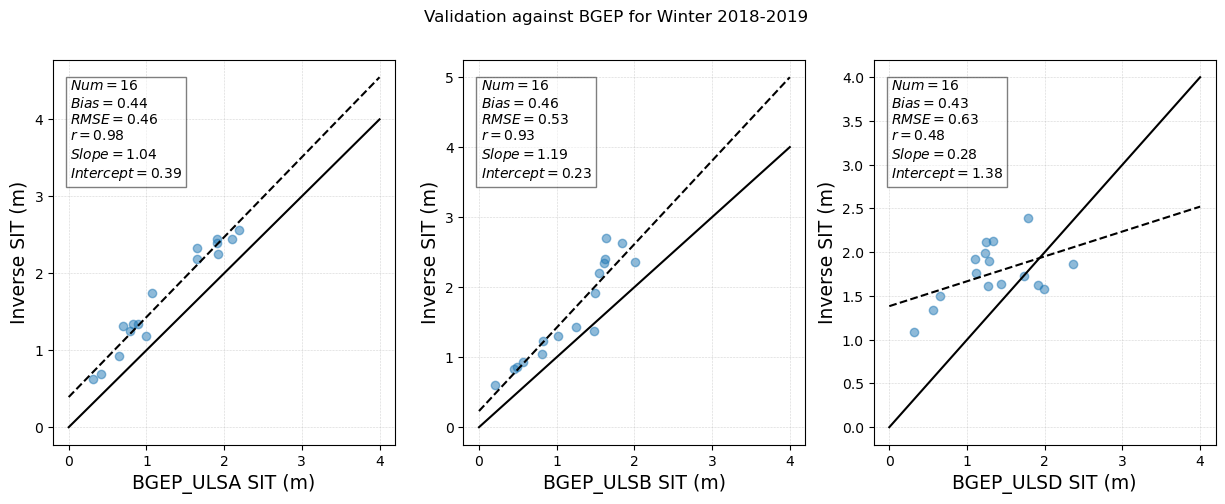

In [ ]:
fig = plt.figure(figsize = (15, 5))
plt.suptitle('Validation against BGEP for Winter 2018-2019')

plt.subplot(131)

plt.scatter(BGEP_ice(BGEP_SIT_ULSA, date), inverse_ice(inverse_ice_files, 235, 148), alpha = 0.5)
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('BGEP_ULSA SIT (m)', fontsize = 13.5)
plt.ylabel('Inverse SIT (m)', fontsize = 13.5)
plt.plot([0,4] , [0,4], 'k-')

md_ice_inverse, rmse_ice_inverse, r2_ice_inverse, slope, intercept = analyse(inverse_ice(inverse_ice_files, 235, 148), BGEP_ice(BGEP_SIT_ULSA, date))
r_ice = pearson(BGEP_ice(BGEP_SIT_ULSA, date), inverse_ice(inverse_ice_files, 235, 148))

textstr = '\n'.join((
    rf'$Num = {len(inverse_ice(inverse_ice_files, 235, 148))}$',
    rf'$Bias={md_ice_inverse:.2f}$',
    rf'$RMSE={rmse_ice_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

x_values = np.array([0,4])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--')

plt.subplot(132)
plt.scatter(BGEP_ice(BGEP_SIT_ULSB, date), inverse_ice(inverse_ice_files, 225, 153), alpha = 0.5)
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('BGEP_ULSB SIT (m)', fontsize = 13.5)
plt.ylabel('Inverse SIT (m)', fontsize = 13.5)
plt.plot([0,4] , [0,4], 'k-')

md_ice_inverse, rmse_ice_inverse, r2_ice_inverse, slope, intercept = analyse(inverse_ice(inverse_ice_files, 225, 153), BGEP_ice(BGEP_SIT_ULSB, date))
r_ice = pearson(BGEP_ice(BGEP_SIT_ULSB, date), inverse_ice(inverse_ice_files, 225, 153))

textstr = '\n'.join((
    rf'$Num = {len(inverse_ice(inverse_ice_files, 225, 153))}$',
    rf'$Bias={md_ice_inverse:.2f}$',
    rf'$RMSE={rmse_ice_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

x_values = np.array([0,4])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--')

plt.subplot(133)
plt.scatter(BGEP_ice(BGEP_SIT_ULSD, date), inverse_ice(inverse_ice_files, 234, 134), alpha = 0.5)
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('BGEP_ULSD SIT (m)', fontsize = 13.5)
plt.ylabel('Inverse SIT (m)', fontsize = 13.5)
plt.plot([0,4] , [0,4], 'k-')

md_ice_inverse, rmse_ice_inverse, r2_ice_inverse, slope, intercept = analyse(inverse_ice(inverse_ice_files, 234, 134), BGEP_ice(BGEP_SIT_ULSD, date))
r_ice = pearson(BGEP_ice(BGEP_SIT_ULSD, date), inverse_ice(inverse_ice_files, 234, 134))

textstr = '\n'.join((
    rf'$Num = {len(inverse_ice(inverse_ice_files, 234, 134))}$',
    rf'$Bias={md_ice_inverse:.2f}$',
    rf'$RMSE={rmse_ice_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

x_values = np.array([0,4])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--')


In [43]:
def ice_OIB(OIB_files):

    SIT_OIB = nc.Dataset(OIB_files).variables['Sea Ice Thickness'][:,:]
    return SIT_OIB

In [44]:
## Validation against OIB

OIB_files = ["/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190408.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190412.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190419.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190420.nc",
             "/home/erb/masterproject/MSCI_project/validation_data/OIB_data/OIB_201904/20190422.nc"]

inverse_ice = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy']

awismos_file = ['/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201904-fv2p4.nc']

awismos = nc.Dataset(awismos_file[0])
awismos.variables.keys()
SIT_awismos = awismos.variables['sea_ice_thickness'][0][36:396,36:396][::-1, :]

lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

sie_path = '/home/erb/masterproject/MSCI_project/snow_ice/carmen/SIE/SIE_masking_25km_2018-2019_season.pkl'
f = open(sie_path,'rb')
sie_file = pickle.load(f)
sie_map  = sie_file['20190415']

OIB_array = []
for i in range(len(OIB_files)):
    OIB_array.append(nc.Dataset(OIB_files[i]).variables['Sea Ice Thickness'][:,:])

In [45]:
SIT_OIB, SIT_OIB_2 = [], []
ice_inverse = []
ice_awismos = []


for i in range(len(OIB_files)):
    
    file_OIB = ice_OIB(OIB_files[i])
    inverse_ice_data = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1000_iteration1000000_date_window3j_error0.05_alphacs20.75_hierarchicalno_ice.npy')
    inverse_ice_stddev = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1000_iteration1000000_date_window3j_error0.05_alphacs20.75_hierarchicalno_ice_stddev.npy')

    inverse_ice_data = mask_high_error(inverse_ice_stddev, inverse_ice_data)
    inverse_ice_data = mask_sie(sie_map, inverse_ice_data)

    for k in range(360):
        for j in range(360):
            if not (file_OIB.mask[k][j]) and not np.isnan(inverse_ice_data[k][j]):
                ice_inverse.append(inverse_ice_data[k][j])
                SIT_OIB.append(file_OIB[k][j])


for i in range(len(OIB_files)):
    
    file_OIB = ice_OIB(OIB_files[i])

    for k in range(360):
        for j in range(360):
            if not (file_OIB.mask[k][j]) and not np.isnan(SIT_awismos[k][j]):
                ice_awismos.append(SIT_awismos[k][j])
                SIT_OIB_2.append(file_OIB[k][j])

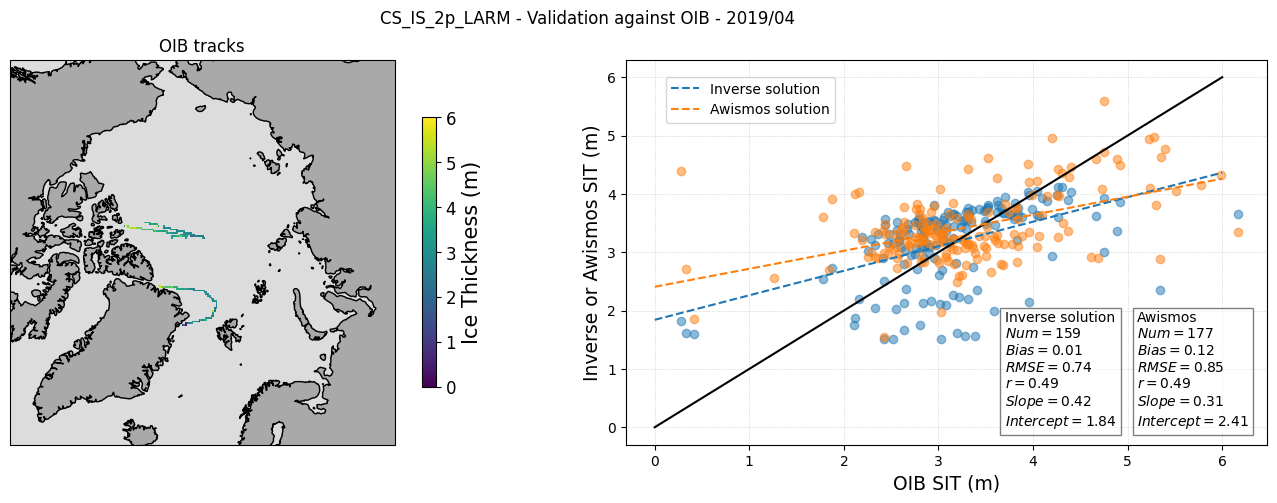

In [47]:
fig = plt.figure(figsize = (17,5))
spec = gridspec.GridSpec(ncols=2, nrows=1,wspace=0.2, height_ratios=[1], width_ratios=[1.3, 1.5])

plt.rcParams['text.usetex'] = False
plt.suptitle('CS_IS_2p_LARM - Validation against OIB - 2019/04')



ax1 = fig.add_subplot(spec[0], projection=ccrs.NorthPolarStereo())
ax1.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax1.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax1.coastlines()
ax1.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax1.pcolormesh(lon_g,lat_g, OIB_array[0],cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 6)
p_map = ax1.pcolormesh(lon_g,lat_g, OIB_array[1],cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 6)
p_map = ax1.pcolormesh(lon_g,lat_g, OIB_array[2],cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 6)
p_map = ax1.pcolormesh(lon_g,lat_g, OIB_array[3],cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 6)
p_map = ax1.pcolormesh(lon_g,lat_g, OIB_array[4],cmap='viridis',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 6)
plt.title('OIB tracks')
a = fig.colorbar(p_map,shrink=0.7, pad=0.05, orientation = 'vertical')
a.ax.tick_params(labelsize=12)
a.set_label('Ice Thickness (m)',fontsize=15)


ax2 = fig.add_subplot(spec[1])
ax2.scatter(SIT_OIB, ice_inverse, alpha = 0.5)
ax2.scatter(SIT_OIB_2, ice_awismos, alpha = 0.5)
ax2.plot([0,6] , [0,6], 'k-')
ax2.grid(linestyle='dotted', linewidth ='0.4')
ax2.set_xlabel('OIB SIT (m)', fontsize = 13.5)
ax2.set_ylabel('Inverse or Awismos SIT (m)', fontsize = 13.5)

md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(ice_inverse, SIT_OIB)
r_snow = pearson(SIT_OIB, ice_inverse)

textstr = '\n'.join((
    rf'Inverse solution',
    rf'$Num = {len(ice_inverse)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
ax2.text(3.7, 2, textstr, bbox=box_props, verticalalignment='top')

x_values = np.array([0,6])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, '--', label = 'Inverse solution')


md_snow_inverse, rmse_snow_inverse, r2_snow_inverse, slope, intercept = analyse(ice_awismos, SIT_OIB_2)
r_snow = pearson(SIT_OIB_2, ice_awismos)

textstr = '\n'.join((
    rf'Awismos',
    rf'$Num = {len(ice_awismos)}$',
    rf'$Bias={md_snow_inverse:.2f}$',
    rf'$RMSE={rmse_snow_inverse:.2f}$',
    rf'$r = {r_snow:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
ax2.text(5.1, 2, textstr, bbox=box_props, verticalalignment='top')

# Regression line
x_values = np.array([0,6])
y_values = slope * x_values + intercept
ax2.plot(x_values, y_values, '--', label = "Awismos solution")

fig.legend(loc = "upper right",bbox_to_anchor=(0.65, 0.86))

save_fig = 0

if save_fig == 1: 
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation/comparison_oib.png', dpi = 300)


In [ ]:
## Validation against SUMATA
sumata_f11 = ['/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F11_201811_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F11_201812_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F11_201901_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F11_201902_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F11_201903_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F11_201904_SMLG_ERA5_EASE.nc']

sumata_f12 = ['/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F12_201811_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F12_201812_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F12_201901_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F12_201902_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F12_201903_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F12_201904_SMLG_ERA5_EASE.nc']

sumata_f13 = ['/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F13_201811_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F13_201812_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F13_201901_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F13_201902_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F13_201903_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F13_201904_SMLG_ERA5_EASE.nc']

sumata_f14 = ['/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F14_201811_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F14_201812_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F14_201901_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F14_201902_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F14_201903_SMLG_ERA5_EASE.nc',
            '/home/erb/masterproject/MSCI_project/validation_data/SUMATA_data/binned_data/F14_201904_SMLG_ERA5_EASE.nc']

sumata_ice_f11, sumata_ice_f12, sumata_ice_f13, sumata_ice_f14 = [], [], [], []
lon_f11, lat_f11, lon_f12, lat_f12, lon_f13, lat_f13, lon_f14, lat_f14 = [], [], [], [], [], [], [], []

for i in range(len(sumata_f11)):
    sumata_ice_f11.append(nc.Dataset(sumata_f11[i]).variables['sea_ice_thickness'][:])
    sumata_ice_f12.append(nc.Dataset(sumata_f12[i]).variables['sea_ice_thickness'][:])
    sumata_ice_f13.append(nc.Dataset(sumata_f13[i]).variables['sea_ice_thickness'][:])
    sumata_ice_f14.append(nc.Dataset(sumata_f14[i]).variables['sea_ice_thickness'][:])

    lon_f11.append(nc.Dataset(sumata_f11[i]).variables['ease_lon'][:])
    lat_f11.append(nc.Dataset(sumata_f11[i]).variables['ease_lat'][:])

    lon_f12.append(nc.Dataset(sumata_f12[i]).variables['ease_lon'][:])
    lat_f12.append(nc.Dataset(sumata_f12[i]).variables['ease_lat'][:])

    lon_f13.append(nc.Dataset(sumata_f13[i]).variables['ease_lon'][:])
    lat_f13.append(nc.Dataset(sumata_f13[i]).variables['ease_lat'][:])
        
    lon_f14.append(nc.Dataset(sumata_f14[i]).variables['ease_lon'][:])
    lat_f14.append(nc.Dataset(sumata_f14[i]).variables['ease_lat'][:])


In [ ]:
inverse_ice_file = ["/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201811/15tesselationDelaunay_initcell1000_iteration1000000_date_window5j_error0.01_ice.npy",
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201812/15tesselationDelaunay_initcell1000_iteration1000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201901/15tesselationDelaunay_initcell1000_iteration1000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201902/15tesselationDelaunay_initcell1000_iteration1000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201903/15tesselationDelaunay_initcell1000_iteration1000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1000_iteration1000000_date_window5j_error0.01_ice.npy']

def inverse_ice(inverse_ice_file):
    ice_inverse = []
    for i in range(len(inverse_ice_file)):
        ice_inverse.append(np.load(inverse_ice_file[i]))

    return ice_inverse

ice_inverse_f11, ice_inverse_f12, ice_inverse_f13, ice_inverse_f14 = [], [], [], []

for i in range(len(ice_inverse)):
    ice_inverse_f11.append(ice_inverse[i][229][182])
    ice_inverse_f12.append(ice_inverse[i][229][182])
    ice_inverse_f13.append(ice_inverse[i][228][183])
    ice_inverse_f14.append(ice_inverse[i][228][185])

IndexError: invalid index to scalar variable.

In [ ]:
fig = plt.figure(figsize = (20, 5))
plt.suptitle('Validation against SUMATA for Winter 2018-2019')

plt.subplot(141)

plt.scatter(sumata_ice_f11, ice_inverse_f11, alpha = 0.5)
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('SUMATA F11 SIT (m)', fontsize = 13.5)
plt.ylabel('Inverse SIT (m)', fontsize = 13.5)
plt.plot([0,4] , [0,4], 'k-')

md_ice_inverse, rmse_ice_inverse, r2_ice_inverse, slope, intercept = analyse(ice_inverse_f11, sumata_ice_f11)
r_ice = pearson(sumata_ice_f11, ice_inverse_f11)

textstr = '\n'.join((
    rf'$Bias={md_ice_inverse:.2f}$',
    rf'$RMSE={rmse_ice_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

x_values = np.array([0,4])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--')

plt.subplot(142)
plt.scatter(sumata_ice_f12, ice_inverse_f12, alpha = 0.5)
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('SUMATA F12 SIT (m)', fontsize = 13.5)
plt.ylabel('Inverse SIT (m)', fontsize = 13.5)
plt.plot([0,4] , [0,4], 'k-')

md_ice_inverse, rmse_ice_inverse, r2_ice_inverse, slope, intercept = analyse(ice_inverse_f12, sumata_ice_f12)
r_ice = pearson(sumata_ice_f12, ice_inverse_f12)

textstr = '\n'.join((
    rf'$Bias={md_ice_inverse:.2f}$',
    rf'$RMSE={rmse_ice_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

x_values = np.array([0,4])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--')

plt.subplot(143)
plt.scatter(sumata_ice_f13, ice_inverse_f13, alpha = 0.5)
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('SUMATA F13 SIT (m)', fontsize = 13.5)
plt.ylabel('Inverse SIT (m)', fontsize = 13.5)
plt.plot([0,4] , [0,4], 'k-')

md_ice_inverse, rmse_ice_inverse, r2_ice_inverse, slope, intercept = analyse(ice_inverse_f13, sumata_ice_f13)
r_ice = pearson(sumata_ice_f13, ice_inverse_f13)

textstr = '\n'.join((
    rf'$Bias={md_ice_inverse:.2f}$',
    rf'$RMSE={rmse_ice_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

x_values = np.array([0,4])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--')

plt.subplot(144)
plt.scatter(sumata_ice_f14, ice_inverse_f14, alpha = 0.5)
plt.grid(linestyle='dotted', linewidth ='0.4')
plt.xlabel('SUMATA F14 SIT (m)', fontsize = 13.5)
plt.ylabel('Inverse SIT (m)', fontsize = 13.5)
plt.plot([0,4] , [0,4], 'k-')

md_ice_inverse, rmse_ice_inverse, r2_ice_inverse, slope, intercept = analyse(ice_inverse_f14, sumata_ice_f14)
r_ice = pearson(sumata_ice_f14, ice_inverse_f14)

textstr = '\n'.join((
    rf'$Bias={md_ice_inverse:.2f}$',
    rf'$RMSE={rmse_ice_inverse:.2f}$',
    #rf'$R^2={r2_snow_inverse:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=box_props)

x_values = np.array([0,4])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, 'k--')

In [ ]:
## Comparison against Awismos

path_awismos = ['/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2018/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201811-fv2p4.nc',
                '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2018/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201812-fv2p4.nc',
                '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201901-fv2p4.nc',
                '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201902-fv2p4.nc',
                '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201903-fv2p4.nc',
                '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201904-fv2p4.nc']

file_awismos = []
for i in range(len(path_awismos)):
    file_awismos.append(nc.Dataset(path_awismos[i]))

def ice_awismos(path_awismos):

    SIT_awismos = nc.Dataset(path_awismos).variables['sea_ice_thickness'][0][36:396,36:396][::-1, :]
    return SIT_awismos

lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

inverse_delaunay_ice_files = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201811/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201812/15tesselationDelaunay_initcell1500_iteration1500000_date_window7j_errorinput_alphacs20.75_hierarchicalno_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201901/15tesselationDelaunay_initcell1500_iteration1500000_date_window7j_errorinput_alphacs20.75_hierarchicalno_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201902/15tesselationDelaunay_initcell1500_iteration1500000_date_window7j_errorinput_alphacs20.75_hierarchicalno_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201903/15tesselationDelaunay_initcell1500_iteration1500000_date_window7j_errorinput_alphacs20.75_hierarchicalno_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell1500_iteration1500000_date_window7j_errorinput_alphacs20.75_hierarchicalno_ice.npy']

inverse_voronoi_ice_files = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201811/tesselationVoronoi_initcell1000_iteration700000_date_window+-2j_error0.01_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201812/tesselationVoronoi_initcell1000_iteration700000_date_window+-2j_error0.01_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201901/tesselationVoronoi_initcell1000_iteration700000_date_window+-2j_error0.01_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201902/tesselationVoronoi_initcell1000_iteration700000_date_window+-2j_error0.01_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201903/tesselationVoronoi_initcell1000_iteration700000_date_window+-2j_error0.01_ice.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/tesselationVoronoi_initcell1000_iteration700000_date_window+-2j_error0.01_ice.npy']

def inverse_ice(inverse_ice_files, path_awismos):
    ice_inverse, SIT_awismos = [], []
    file_awismos = nc.Dataset(path_awismos).variables['sea_ice_thickness'][0][36:396,36:396][::-1, :]


    ice_inverse_data = np.load(inverse_ice_files)

    for k in range(360):
        for j in range(360):
        #if not SIT_awismos.mask[k][j] and not np.isnan(ice_inverse_data[k][j]):
            if not np.isnan(ice_inverse_data[k][j]) and not np.isnan(file_awismos[k][j]):
                ice_inverse.append(ice_inverse_data[k][j])
                SIT_awismos.append(file_awismos[k][j])
    return ice_inverse, SIT_awismos

FileNotFoundError: [Errno 2] No such file or directory: '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201812/15tesselationDelaunay_initcell1500_iteration1500000_date_window7j_errorinput_alphacs20.75_hierarchicalno_ice.npy'

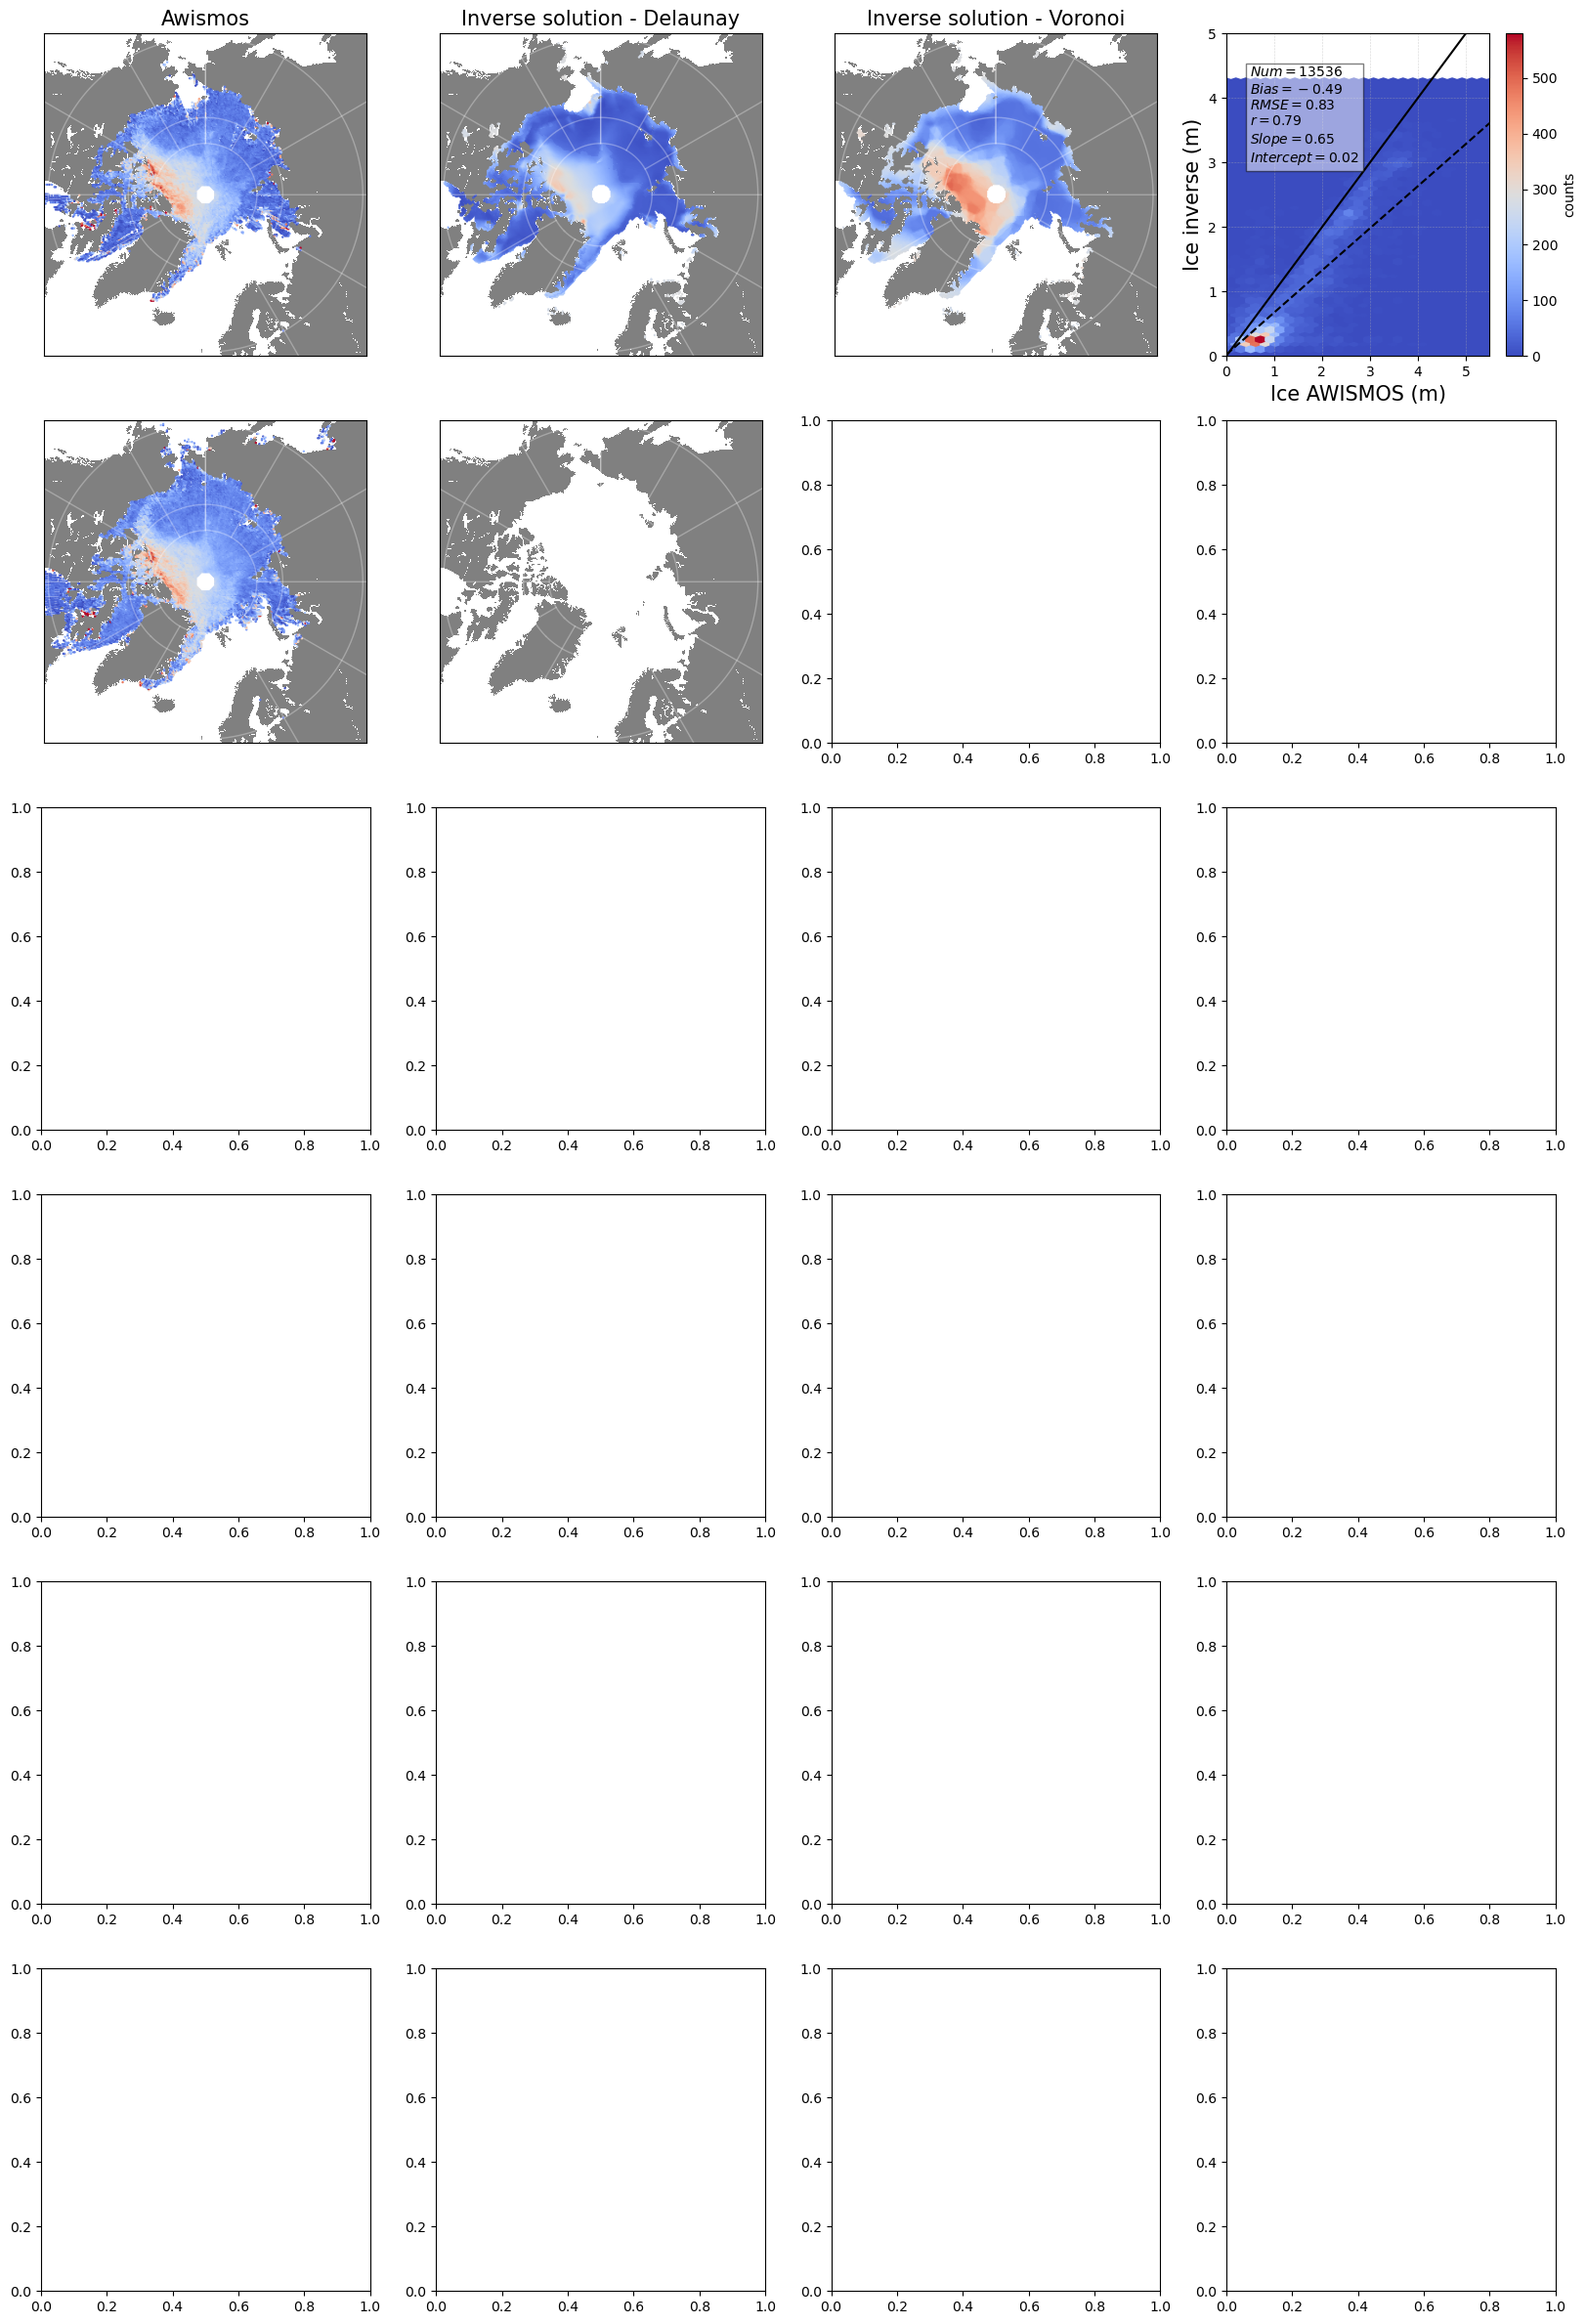

In [ ]:
fig, axs = plt.subplots(6, 4, figsize=(20, 30))
#plt.suptitle('Validation against AWISMOS for the Winter 2018-2019')

vmax, vmin = 6, 0


for i in range(6):
    if i == 0 :
        axs[i,0].set_title('Awismos', fontsize = 15)
    m1 = Basemap(ax=axs[i, 0],projection='lcc', resolution=None, lat_0=-90, lon_0=0, 
                lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
    draw_map(m1)
    sc = m1.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=ice_awismos(path_awismos[i]), 
                   cmap="coolwarm", vmin=vmin, vmax=vmax)

    if i == 0 :
        axs[i,1].set_title('Inverse solution - Delaunay', fontsize = 15)

    m2 = Basemap(ax=axs[i, 1], projection='lcc', resolution=None, lat_0=-90, lon_0=0, 
                lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
    draw_map(m2)
    sc = m2.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=np.load(inverse_delaunay_ice_files[i]), 
                   cmap="coolwarm", vmin=vmin, vmax=vmax)

    if i == 0 :
        axs[i,2].set_title('Inverse solution - Voronoi', fontsize = 15)

    m3 = Basemap(ax=axs[i, 2], projection='lcc', resolution=None, lat_0=-90, lon_0=0, 
                lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
    draw_map(m3)
    sc = m3.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=np.load(inverse_voronoi_ice_files[i]), 
                   cmap="coolwarm", vmin=vmin, vmax=vmax)

    ax3 = axs[i, 3]
    ice_inverse, SIT_awismos = inverse_ice(inverse_delaunay_ice_files[i], path_awismos[i])
    hb = ax3.hexbin(SIT_awismos, ice_inverse, gridsize=50, cmap='coolwarm')
    #ax3.scatter(SIT_awismos , ice_inverse, alpha = 0.5)
    ax3.set_xlabel('Ice AWISMOS (m)', fontsize = 15)
    ax3.set_ylabel('Ice inverse (m)', fontsize = 15)
    ax3.set_ylim(0, 5)
    ax3.set_xlim(0, 5.5)
    ax3.grid(linestyle='dotted', linewidth ='0.4')
    ax3.plot([0,5] , [0,5], 'k-')
    md_ice_inverse, rmse_ice_inverse, r2_ice_inverse, slope, intercept = analyse(ice_inverse, SIT_awismos)
    r_ice = pearson(SIT_awismos, ice_inverse)
    textstr = '\n'.join((
    rf'$Num = {len(ice_inverse)}$',
    rf'$Bias={md_ice_inverse:.2f}$',
    rf'$RMSE={rmse_ice_inverse:.2f}$',
    #rf'$R^2={r2_ice_inverse:.2f}$',
    rf'$r = {r_ice:.2f}$',
    rf'$Slope = {slope:.2f}$',
    rf'$Intercept = {intercept:.2f}$'))
    box_props = dict(boxstyle='square', facecolor= 'white', alpha=0.5)
    #ax3.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
    #     verticalalignment='top', bbox=box_props)
    ax3.text(0.5, 4.5, textstr, bbox=box_props, verticalalignment='top')
    x_values = np.array([0,5.5])
    y_values = slope * x_values + intercept
    ax3.plot(x_values, y_values, 'k--', label='Best fit')
    cb = fig.colorbar(hb, ax=ax3)
    cb.set_label('counts')




plt.tight_layout()
cbar = fig.colorbar(sc, ax=axs[:, :2], orientation='vertical', location = 'left',fraction=0.02, pad=0.02)
cbar.set_label('Ice thickness (m)')

fig.suptitle('Comparison with AWISMOS for the Winter 2018-2019', fontsize=16, y=1.01)

# Afficher le graphique
if save_fig == 1: 
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation/comparison_awismos_2018-2019.png')

plt.show()


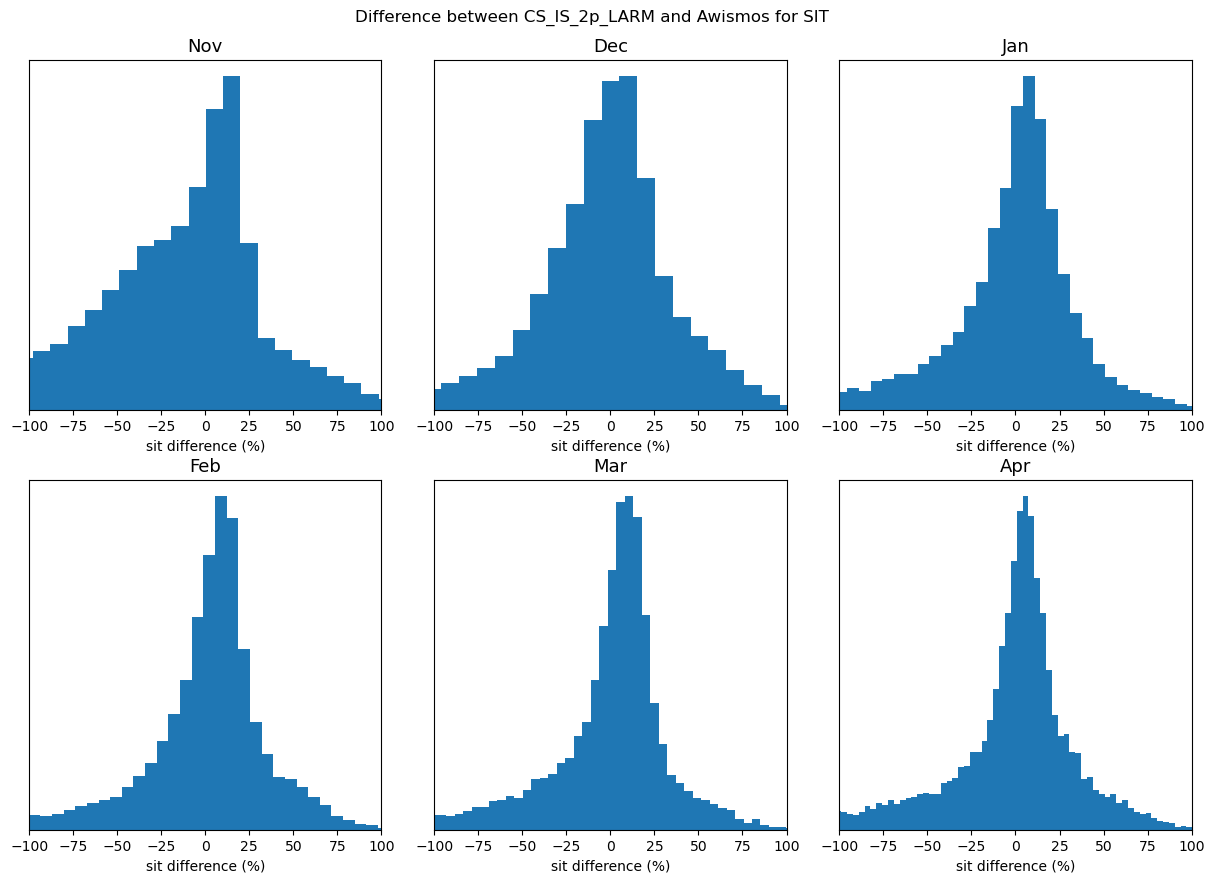

In [ ]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(15,10))
spec = gridspec.GridSpec(ncols=3, nrows=2, hspace=0.2, wspace=0.15)

plt.suptitle('Difference between CS_IS_2p_LARM and Awismos for SIT', y = 0.93)

month = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']

for i in range(6):
    ax = fig.add_subplot(spec[i])
    ax.set_title(month[i], fontsize = 13)
    ice_inverse, ice_awismos = np.array(inverse_ice(inverse_delaunay_ice_files[i], path_awismos[i]))
    difference = (ice_inverse - ice_awismos)*100/ice_inverse
    ax.hist(difference, bins = 250)
    ax.set_xlim(-100, 100)
    ax.yaxis.set_ticklabels([])
    ax.set_yticks([])
    #ax.set_xticks([-20, -15, -10, -5, 0, 5, 10, 15, 20])
    ax.set_xlabel('sit difference (%)')
    #ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    #ax.yaxis.set_ticklabels([])

    #ax.grid()
    